In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading the dependencies

- Downloading the dataset from kaggle using the kaggle API
- Downloading pretrained GloVe embeddings

In [ ]:
from IPython.display import clear_output

!pip install kaggle
%env KAGGLE_USERNAME=xerefic
%env KAGGLE_KEY=83aac7088c3bb8150fcf8197ab22c67b

!kaggle competitions download -c fake-news
!unzip /content/train.csv.zip
!unzip /content/test.csv.zip
!rm *.zip

clear_output()

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!mkdir embeddings
!mkdir embeddings/glove.6B
!unzip /content/glove.6B.zip -d "/content/embeddings/glove.6B/"

clear_output()

---

# Importing Libraries

In [ ]:
import re
import numpy as np
import pandas as pd

import os
import gc
import sys
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import keras

---

# Processing the Dataset

Concatenating the title and text to increase the learning scope of our model.

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train = train.dropna()
test = test.dropna()

train['text'] = train['title']+train['text']
test['text'] = test['title']+test['text']

train = train.drop(columns=['id', 'title', 'author'])
test = test.drop(columns=['id', 'title', 'author'])

Visualizing the dataset

In [ ]:
train.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You FiredWhy the Truth...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


Converting into a iterable format

In [ ]:
x_train = train['text'].to_numpy()
y_train = train['label'].to_numpy()
x_test = test['text'].to_numpy()

## Visualizing the data

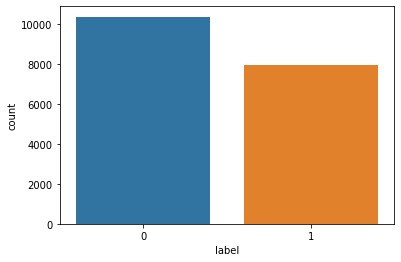

In [ ]:
sns.countplot(x='label', data=train)

---

# Creating the Vocabulary

In [ ]:
embeddings = {}
with open("/content/embeddings/glove.6B/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = " ".join(t for t in values[:-50])
        vector = np.asarray(values[-50:], "float64")
        embeddings[word] = vector

In [ ]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
vectorizer.adapt(x_train)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18146 words (1854 misses)


Saving the vocabulary data to load during testing phase

In [ ]:
DUMP = "/content/drive/MyDrive/Projects/Hackathons/FakeNews-Team_Hackers/checkpoints/embeddings/"

pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}, 
            open(os.path.join(DUMP, "vectorizer.pkl"), "wb"))

pickle.dump(embedding_matrix,
            open(os.path.join(DUMP, "embedding.pkl"), "wb"))

---

# Model Architecture

In [ ]:
model = Sequential()

model.add(Embedding(num_tokens, embedding_dim, keras.initializers.Constant(embedding_matrix), trainable=False ))
model.add(Dropout(0.5))

model.add(LSTM(384))
model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1000100   
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 384)               668160    
_________________________________________________________________
dropout_1 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 385       
Total params: 1,668,645
Trainable params: 668,545
Non-trainable params: 1,000,100
_________________________________________________________________


# Training Phase

Converting the input to the encoding format

In [ ]:
x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_test = vectorizer(np.array([[s] for s in x_test])).numpy()

## Training the model

In [ ]:
history = model.fit(x_train, y_train, epochs = 16, batch_size = 64)

Epoch 1/16
286/286 [==============================] - 12s 27ms/step - loss: 0.6391 - accuracy: 0.6444
Epoch 2/16
286/286 [==============================] - 8s 27ms/step - loss: 0.6290 - accuracy: 0.6494
Epoch 3/16
286/286 [==============================] - 8s 27ms/step - loss: 0.6309 - accuracy: 0.6580
Epoch 4/16
286/286 [==============================] - 8s 27ms/step - loss: 0.6586 - accuracy: 0.6187
Epoch 5/16
286/286 [==============================] - 8s 27ms/step - loss: 0.6598 - accuracy: 0.6148
Epoch 6/16
286/286 [==============================] - 8s 27ms/step - loss: 0.6515 - accuracy: 0.6322
Epoch 7/16
286/286 [==============================] - 8s 27ms/step - loss: 0.6454 - accuracy: 0.6339
Epoch 8/16
286/286 [==============================] - 8s 27ms/step - loss: 0.6310 - accuracy: 0.6472
Epoch 9/16
286/286 [==============================] - 8s 27ms/step - loss: 0.6087 - accuracy: 0.6734
Epoch 10/16
286/286 [==============================] - 8s 27ms/step - loss: 0.5630 - accur

Saving the model weights to load during the test phase

In [ ]:
model.save_weights("/content/drive/MyDrive/Projects/Hackathons/FakeNews-Team_Hackers/checkpoints/embeddings/")

## Visualizing the Loss and Accuracy

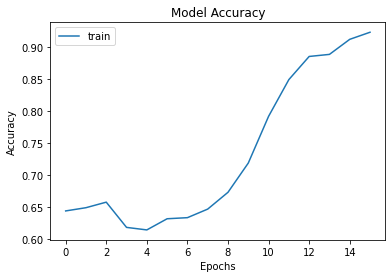

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train'], loc='best')
plt.show()

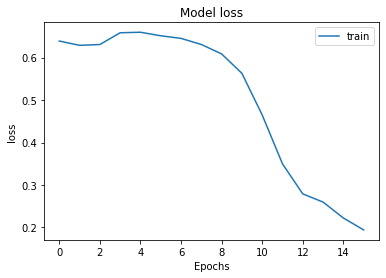

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train'], loc='best')
plt.show()

---

# Testing Phase

In [ ]:
DUMP = "/content/drive/MyDrive/Projects/Hackathons/FakeNews-Team_Hackers/checkpoints/embeddings/"

In [ ]:
def isFake(text, DUMP):
    vectorizer_disk = pickle.load(open(os.path.join(DUMP, "vectorizer.pkl"), "rb"))
    embedding_matrix = pickle.load(open(os.path.join(DUMP, "embedding.pkl"), "rb"))

    vectorizer = TextVectorization.from_config(vectorizer_disk['config'])
    vectorizer.adapt(tensorflow.data.Dataset.from_tensor_slices(["xyz"]))
    vectorizer.set_weights(vectorizer_disk['weights'])

    embedding_dim = 50

    model = Sequential()
    model.add(Embedding(len(embedding_matrix), embedding_dim, keras.initializers.Constant(embedding_matrix), trainable=False))
    model.add(Dropout(0.5))
    model.add(LSTM(384))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
    model.load_weights(DUMP)

    text = np.array(text)
    text = vectorizer([text]).numpy()
    y_preds = model.predict(text)

    return "The news is {0} % Fake".format(int(y_preds.item()*10000)/100)